In [251]:
import sys
sys.path.append('/camin1/hkkim/control-net/')
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.tutorial.utils import fetch_mics_data
import numpy as np
from scripts.io_mesh import load_mesh_data
from brainspace.datasets import load_parcellation, load_conte69
import nibabel as nib
import os
import pandas as pd
import numpy as np
from brainstat.datasets import fetch_mask, fetch_template_surface

from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from tqdm import tqdm

# Thickness

In [189]:
[labels_lh, ctab_lh, names_lh] = nib.freesurfer.io.read_annot('./MPC/parcellations/lh.schaefer-300_mics.annot')
[labels_rh, ctab_rh, names_rh] = nib.freesurfer.io.read_annot('./MPC/parcellations/rh.schaefer-300_mics.annot')


In [190]:
label = load_parcellation('schaefer', scale=300, join=True)

In [191]:
os.system('cp -r /usr/local/freesurfer7/subjects/fsaverage5 ./')

0

In [192]:
def fs_avg_5_mapping(src_sub, target_sub, hemi):
    command = f'export SUBJECTS_DIR= ; \
    mri_surf2surf \
    --srcsubject {src_sub} \
    --sval thickness \
    --trgsubject {target_sub} \
    --tval fsaverage5.thickness \
    --hemi {hemi} \
    --surfreg sphere.reg \
    --src_type curv \
    --trg_type curv >/dev/null 2>&1'
    


    os.system('export SUBJECTS_DIR=/')
    os.system(command)
    os.system(f'mv /{target_sub}/surf/{hemi}.fsaverage5.thickness /{src_sub}/surf/{hemi}.fsaverage5.thickness')


In [193]:
def get_complete_subject_list(root_path):
    subjects = []
    for sub in os.listdir(f'{root_path}'):
        if os.path.exists(f'{root_path}/{sub}/label'):
            if len(os.listdir(f'{root_path}/{sub}/label')) == 91:
                if os.path.exists(f'{root_path}/{sub}/anat/surfaces/micro_profiles'):
                    if len(os.listdir(f'{root_path}/{sub}/anat/surfaces/micro_profiles')) == 92:
                        subjects.append(f'{root_path}/{sub}')
    return subjects

In [194]:
all_subjects = get_complete_subject_list('./surfaces')

In [195]:
len(all_subjects)

236

In [201]:
for subject in tqdm(all_subjects):
    target_sub = os.path.abspath('./fsaverage5')
    subject = os.path.abspath(subject)
    for hemi in ['lh','rh']:
        fs_avg_5_mapping(subject, target_sub, hemi)
        

100%|██████████| 236/236 [28:52<00:00,  7.34s/it]


In [196]:
## load fsaverage5 labels
[labels_lh, ctab_lh, names_lh] = nib.freesurfer.io.read_annot('./MPC/parcellations/lh.schaefer-300_mics.annot', orig_ids=True)
[labels_rh, ctab_rh, names_rh] = nib.freesurfer.io.read_annot('./MPC/parcellations/rh.schaefer-300_mics.annot', orig_ids=True)
labels_rh = labels_rh.astype(int)
labels_lh = labels_lh.astype(int)
labels_rh = labels_rh
fs5_labels = np.concatenate([labels_lh, labels_rh])

In [197]:
parcLength = len(labels_lh)+len(labels_rh)
parc = np.zeros((parcLength))
for (x, _) in enumerate(labels_lh):
    parc[x] = np.where(ctab_lh[:,4] == labels_lh[x])[0][0]
for (x, _) in enumerate(labels_rh):
    parc[x + len(labels_lh)] = np.where(ctab_rh[:,4] == labels_rh[x])[0][0] + len(ctab_lh)
uparcel = np.unique(parc)

In [198]:
schaefer_labels = load_parcellation('schaefer', scale=300, join=True)

In [199]:
def get_fsa5_thickness(src_sub, labels = None):
    thickness_lh = load_mesh_data(f'{src_sub}/surf/lh.fsaverage5.thickness').astype(float)
    thickness_rh = load_mesh_data(f'{src_sub}/surf/rh.fsaverage5.thickness').astype(float)
    thickness = np.concatenate([thickness_lh, thickness_rh])
    if isinstance(labels, type(None)):
        return thickness
    else:
        thickness = pd.DataFrame({'labels':labels, 'thickness':thickness}).groupby('labels').mean().sort_index()
        thickness = thickness.to_numpy().reshape(-1) ## 300*1 thickness
        return thickness

In [202]:
group_thickness = np.zeros((len(all_subjects),302))
demo_info = [] ## syn age
for (i, subject) in enumerate(tqdm(all_subjects)):
    age = float(subject.split('_')[-1])
    group_thickness[i] = get_fsa5_thickness(subject, parc)
    demo_info.append(int(age))

100%|██████████| 236/236 [00:03<00:00, 74.55it/s]


In [203]:
brain_feature_thickness = pd.merge(pd.DataFrame(parc,columns = ['label']), pd.DataFrame(group_thickness).T, left_on=['label'], right_index=True)#.to_csv('/camin1/hkkim/control-net/custom/MPC/brain_feature_thickness.csv', index=False)
label = brain_feature_thickness['label']
brain_feature_thickness.drop('label', axis=1, inplace=True)

In [204]:
brain_feature_thickness = brain_feature_thickness.T

In [205]:
mask = np.asarray([0, int(len(uparcel)/2)])
parc[parc == mask[0]] = 0
parc[parc == mask[1]] = 0

In [120]:
mask

array([  0, 151])

In [206]:
thickness_10 = np.mean(brain_feature_thickness.loc[np.where(np.array(demo_info) == 10)], axis=0)
thickness_80 = np.mean(brain_feature_thickness.loc[np.where(np.array(demo_info) == 80)], axis=0)        


In [207]:
thickness_delta = thickness_80 - thickness_10

In [208]:
mask = schaefer_labels != 0
mapped_thickness = map_to_labels(thickness_delta, schaefer_labels, mask=mask,
                    fill=np.nan)

In [209]:
surf_lh, surf_rh = load_conte69()

In [210]:
group_thickness = pd.DataFrame(group_thickness)
group_thickness['age'] = demo_info

In [211]:
group_thickness.to_csv('group_thickness.csv')

## Modeling

In [212]:
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM


In [213]:
model = FixedEffect(demo_info, "AGE_AT_SCAN")

In [214]:
from brainspace.gradient import GradientMaps

def get_grad_from_MPC(conn_matrix):
    labeling = load_parcellation('schaefer', scale=300, join=True)
    mask = labeling != 0
    del_ls = np.where(conn_matrix.sum(0)==0)[0]
    conn_matrix = np.delete(np.delete(conn_matrix, del_ls, axis=0), del_ls, axis=1)
    grad_map = GradientMaps(n_components=10, random_state=None, approach='dm', kernel='normalized_angle',alignment='procrustes')
    grad_map.fit(conn_matrix, sparsity=0.9)
    grads = grad_map.gradients_.copy()
    for idx in del_ls:
        grads = np.insert(grads, idx, 0, axis=0)
    gradients = map_to_labels(grads[:, 0], labeling, mask=mask,
                        fill=np.nan).tolist()

    return gradients,grads

## Gradient

In [216]:
gradient_features = np.zeros((len(all_subjects),302))
i = 0
for root in all_subjects:
    sub_nm = root.split('/')[-1]
    f = f'anat/surfaces/micro_profiles/{sub_nm}_space-fsaverage5_atlas-schaefer-300_desc-MPC.txt'
    conn_matrix = np.loadtxt(os.path.join(root,f))
    gradients,grads = get_grad_from_MPC(conn_matrix)
    gradient_features[i] = grads[:,0]
    i +=1

In [217]:
gradient_features_df = pd.DataFrame(gradient_features)
gradient_features_df['age'] = demo_info

In [218]:
gradient_features_df.to_csv('brain_gradient_for_modeling.csv',index = False)

## Moment

In [222]:
from scipy.stats import skew, kurtosis
group_mean = np.zeros((len(all_subjects),302))
group_std = np.zeros((len(all_subjects),302))
group_skew = np.zeros((len(all_subjects),302))
group_kurto = np.zeros((len(all_subjects),302))


for i,sub in enumerate(all_subjects):
    sub_nm = sub.split('/')[-1]
    
    # load intensity
    temp = np.loadtxt(f"./surfaces/{sub_nm}/anat/surfaces/micro_profiles/{sub_nm}_space-fsaverage5_atlas-schaefer-300_desc-intensity_profiles.txt")

    # delete nan
    nan_ls = np.unique(np.where(np.isnan(temp))[1])
    inten = np.delete(temp, nan_ls, axis=1)
    
    # momnet
    mean = inten.mean(0)
    std = inten.std(0)
    skew_ = skew(inten)
    kurto_ = kurtosis(inten)
    ## fill medial wall
    
    group_mean[i,1:151],group_mean[i,152:] = mean[:150],mean[150:]
    group_std[i,1:151],group_std[i,152:] = std[:150],std[150:]
    group_skew[i,1:151],group_skew[i,152:] = skew_[:150],skew_[150:]
    group_kurto[i,1:151],group_kurto[i,152:] = kurto_[:150],kurto_[150:]    

In [223]:
group_mean_df = pd.DataFrame(group_mean)
group_mean_df['age'] = demo_info
group_std_df = pd.DataFrame(group_std)
group_std_df['age'] = demo_info
group_skew_df = pd.DataFrame(group_skew)
group_skew_df['age'] = demo_info
group_kurto_df = pd.DataFrame(group_kurto)
group_kurto_df['age'] = demo_info

In [224]:
group_mean_df.to_csv('group_mean.csv',index = False)
group_std_df.to_csv('group_std.csv',index = False)
group_skew_df.to_csv('group_skew.csv',index = False)
group_kurto_df.to_csv('group_kurto.csv',index = False)

## Ventrical

In [226]:
ventrical_vol = np.zeros((len(all_subjects),1))
for i,root in enumerate(all_subjects):
    f = 'stats/brainvol.stats'
    with open(os.path.join(root,f),'r') as f:
        vol=float(f.readlines()[-1].split(',')[-2])
        ventrical_vol[i] = vol


In [227]:
ventrical_vol_df = pd.DataFrame(ventrical_vol)
ventrical_vol_df['age'] = demo_info

<Axes: xlabel='age'>

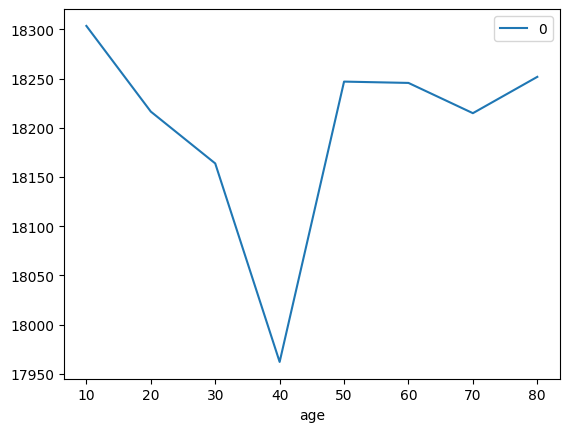

In [228]:
ventrical_vol_df.groupby('age').mean().plot()

## Thickness of 4 lobes

In [229]:
[labels_rh, ctab_rh, names_rh] = nib.freesurfer.io.read_annot('./MPC/parcellations/rh.aparc_mics.annot')
[labels_lh, ctab_lh, names_lh] = nib.freesurfer.io.read_annot('./MPC/parcellations/lh.aparc_mics.annot')

In [230]:
for i in range(len(names_lh)):
    if names_lh[i] != names_rh[i]:
        print(names_lh[i] , names_rh[i])

In [231]:
brain_lobe_mapping = {
    'unknown': 'unknown',
    'bankssts': 'Temporal Lobe',
    'caudalanteriorcingulate': 'unknown',
    'caudalmiddlefrontal': 'Frontal Lobe',
    'corpuscallosum': 'unknown',
    'cuneus': 'Occipital Lobe',
    'entorhinal': 'Temporal Lobe',
    'fusiform': 'Temporal Lobe',
    'inferiorparietal': 'Parietal Lobe',
    'inferiortemporal': 'Temporal Lobe',
    'isthmuscingulate': 'unknown',
    'lateraloccipital': 'Occipital Lobe',
    'lateralorbitofrontal': 'Frontal Lobe',
    'lingual': 'Occipital Lobe',
    'medialorbitofrontal': 'Frontal Lobe',
    'middletemporal': 'Temporal Lobe',
    'parahippocampal': 'Temporal Lobe',
    'paracentral': 'Parietal Lobe',
    'parsopercularis': 'Frontal Lobe',
    'parsorbitalis': 'Frontal Lobe',
    'parstriangularis': 'Frontal Lobe',
    'pericalcarine': 'Occipital Lobe',
    'postcentral': 'Parietal Lobe',
    'posteriorcingulate': 'unknown',
    'precentral': 'Frontal Lobe',
    'precuneus': 'Parietal Lobe',
    'rostralanteriorcingulate': 'unknown',
    'rostralmiddlefrontal': 'Frontal Lobe',
    'superiorfrontal': 'Frontal Lobe',
    'superiorparietal': 'Parietal Lobe',
    'superiortemporal': 'Temporal Lobe',
    'supramarginal': 'Parietal Lobe',
    'frontalpole': 'Frontal Lobe',
    'temporalpole': 'Temporal Lobe',
    'transversetemporal': 'Temporal Lobe',
    'insula': 'unknown',
}


In [232]:
lobe_label_mapping = {
    'unknown' : 0,
    'Frontal Lobe' : 1,
    'Occipital Lobe' : 2,
    'Parietal Lobe' : 3,
    'Temporal Lobe' : 4
    
}

In [233]:
lobes_name = [brain_lobe_mapping[n.decode()] for n in names_rh]
fsa_lobes = [lobes_name[n] for n in labels_lh] + [lobes_name[n] for n in labels_rh]

In [234]:
brain_feature_thickness_by_lobes = brain_feature_thickness.T
brain_feature_thickness_by_lobes['lobe_name'] = fsa_lobes
brain_feature_thickness_by_lobes = brain_feature_thickness_by_lobes.groupby('lobe_name').mean().T
brain_feature_thickness_by_lobes

lobe_name,Frontal Lobe,Occipital Lobe,Parietal Lobe,Temporal Lobe,unknown
0,2.919385,2.250832,2.633127,3.080288,1.763797
1,2.850094,2.522841,2.829792,3.148796,1.820480
2,3.003755,2.562051,2.837033,3.282596,1.910328
3,2.962114,2.482843,2.572268,3.122958,1.816171
4,2.898719,2.447515,2.810146,2.983223,1.779561
...,...,...,...,...,...
231,3.090019,2.586009,2.822135,3.157678,1.824357
232,3.044323,2.588915,2.839175,3.244269,1.867060
233,3.192189,2.556349,2.888946,3.314062,1.887521
234,3.149099,2.294666,2.718898,3.274567,1.860589


In [235]:
age_thickness_lobes_df = pd.DataFrame(columns=brain_feature_thickness_by_lobes.columns)
for age in range(10,81,10):
    by_age = brain_feature_thickness_by_lobes.loc[np.where(np.array(demo_info) == age)]
    age_thickness_lobes_df.loc[age] = np.mean(by_age,axis = 0)

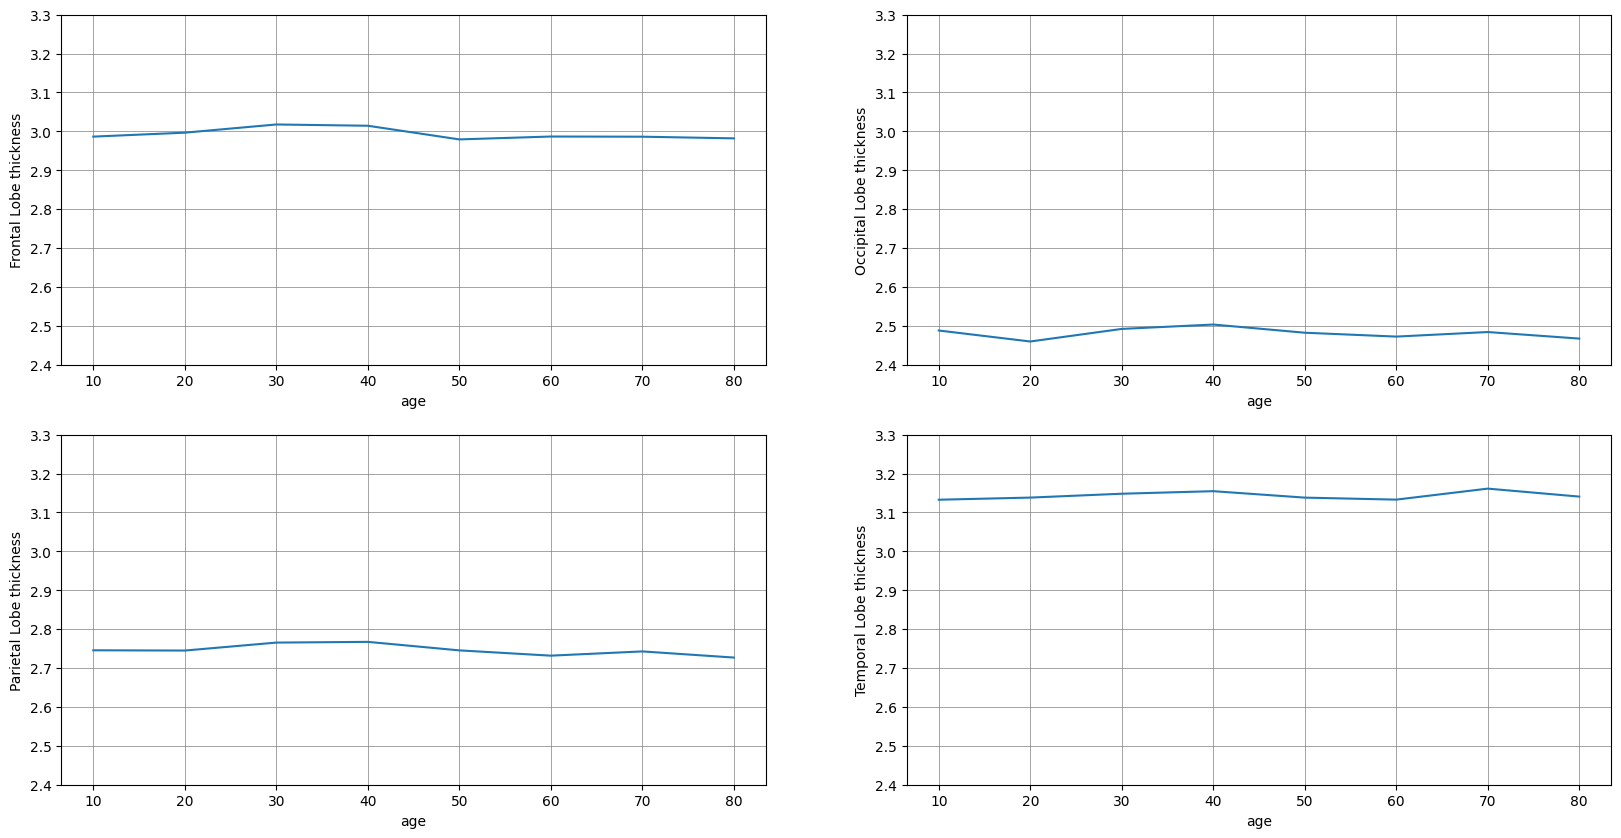

In [236]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(age_thickness_lobes_df.iloc[:,i])
    plt.grid(color='gray', linestyle='-', linewidth=0.5)
    plt.ylim(2.4,3.3)
    plt.xlabel('age')
    plt.ylabel(f'{age_thickness_lobes_df.columns[i]} thickness')

## External data (eNKI)

In [37]:
from monai.metrics import PSNRMetric,MSEMetric
from monai.metrics.regression import SSIMMetric
from monai.transforms import ScaleIntensityRangePercentiles


In [38]:
transform = ScaleIntensityRangePercentiles(lower=0.0, upper=99.5, b_min=0.0, b_max=1, clip=False)

In [46]:
import numpy as np
import pandas as pd
import nibabel as nib
import torch
import os



output_dir = 'output_eNKI/subjects_eNKI_reg'
original_dir = 'subjects_eNKI'
pred = False
metric_df = pd.DataFrame(columns = ['subject_id','original_modality','target_modality','PSNR','SSIM','MSE'])
pnsr_list = []
ssim_list = []
MSE_list = []

for root, dir, files in os.walk(output_dir):
    for f in files:
        if ('T1w' in f) & ('.nii.gz' in f):
            true_f = os.path.join(root,f).replace(output_dir, original_dir).split('_reg')[0] + '.nii.gz'
            true_f.replace('V2','V4')
            pred = nib.load(os.path.join(root,f)).get_fdata()[:,:,:,0]
            pred = torch.tensor(pred).unsqueeze(0)
            true = nib.load(true_f).get_fdata()
            true = torch.tensor(true).unsqueeze(0)
            true = transform(true)

            pnsr_metric = PSNRMetric(torch.max(true))
            ssim_metric = SSIMMetric(3,torch.max(true))
            mse_metric = MSEMetric()
    
            pnsr = pnsr_metric(true.unsqueeze(0),pred.unsqueeze(0))
            ssim = ssim_metric(true.unsqueeze(0),pred.unsqueeze(0))
            mse = mse_metric(true.unsqueeze(0),pred.unsqueeze(0))
            pnsr_list.append(pnsr.item())
            ssim_list.append(ssim.item())
            MSE_list.append(mse.item())
            metric_list = [f,'T1' if 'T2' in f else 'T2',f,pnsr.item(),ssim.item(),mse.item()]
            metric_df = pd.concat([metric_df,pd.DataFrame(np.zeros((1,6)),columns = metric_df.columns)],ignore_index = True)
            metric_df.iloc[-1] = metric_list
            print(f'{f} PSNR: {np.mean(pnsr_list)}, SSIM: {np.mean(ssim_list)}, MSE: {np.mean(MSE_list)}')
            



/tmp/ipykernel_49699/3004689276.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metric_df = pd.concat([metric_df,pd.DataFrame(np.zeros((1,6)),columns = metric_df.columns)],ignore_index = True)
/tmp/ipykernel_49699/3004689276.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'T1w_age_17.386301040649414.nii.gz' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metric_df.iloc[-1] = metric_list
/tmp/ipykernel_49699/3004689276.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'T2' has dtype incompatible with float64, please explicitl

T1w_age_17.386301040649414.nii.gz PSNR: 27.36474806746926, SSIM: 0.8865529894828796, MSE: 0.009858711536323284
T1w_age_19.391780853271484.nii.gz PSNR: 27.915425264335322, SSIM: 0.8937557339668274, MSE: 0.008754560852935021
T1w_age_14.479452133178711.nii.gz PSNR: 27.82018806157309, SSIM: 0.8950141270955404, MSE: 0.008928109495969892
T1w_age_11.339726448059082.nii.gz PSNR: 27.540951879124417, SSIM: 0.8957591652870178, MSE: 0.008717508250975335
T1w_age_15.920547485351562.nii.gz PSNR: 27.727046146677015, SSIM: 0.8982926130294799, MSE: 0.008407831810203388
T1w_age_15.832877159118652.nii.gz PSNR: 27.711137008421904, SSIM: 0.8970412214597067, MSE: 0.008444578099272718
T1w_age_12.106849670410156.nii.gz PSNR: 27.674419631248693, SSIM: 0.8975984794752938, MSE: 0.008617912102802492
T1w_age_16.7780818939209.nii.gz PSNR: 27.595717545743994, SSIM: 0.896143950521946, MSE: 0.008867226329327611
T1w_age_13.545205116271973.nii.gz PSNR: 27.568625046869425, SSIM: 0.8949880401293436, MSE: 0.0086923274884462

In [50]:
metric_df['target_modality'] = metric_df['target_modality'].apply(lambda x: 'T1' if 'T1' in x else 'T2')
metric_df.groupby(['target_modality'])[['PSNR','SSIM','MSE']].mean()

,PSNR,SSIM,MSE
target_modality,,,
T1,27.349524,0.891238,0.008649


In [54]:
metric_table = metric_df.groupby(['target_modality'])[['PSNR','SSIM','MSE']].mean()
metric_table.round(3).astype(str) + '±' + metric_df.groupby(['target_modality'])[['PSNR','SSIM','MSE']].std().round(3).astype(str)

,PSNR,SSIM,MSE
target_modality,,,
T1,27.35±0.88,0.891±0.009,0.009±0.001


## Evaluating modality transfer

In [192]:
from scripts.utils import inference_sample,dataloader,cleanup_DDP_checkpoint,parse_train_files,transformation
from scripts.utils import load_config
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")
train_files = parse_train_files('./subjects/subjects.txt')
batch_size = 1
infer_dl = dataloader(train_files,batch_size=batch_size,device='cuda',cache_rate=0.0,num_workers=10)

In [183]:
args = load_config("config.json")

In [167]:
from scripts.models import load_vae_gan,load_unet,load_control_net
from monai.networks.schedulers import PNDMScheduler
autoencoder = load_vae_gan().to(args.device).eval()
controlnet = load_control_net().to(args.device).eval()
unet = load_unet().to(args.device).eval()
## cleanup DDP checkpoint, we saved model with DDP
autoencoder = cleanup_DDP_checkpoint(autoencoder, args.trained_vae_gan_path)
unet = cleanup_DDP_checkpoint(unet, args.trained_diffusion_path)
controlnet = cleanup_DDP_checkpoint(controlnet, args.trained_controlnet_path)
noise_scheduler = PNDMScheduler(num_train_timesteps = 1000)

In [184]:
def encode(image,autoencoder):
    latent = autoencoder.encode_stage_2_inputs(image)
    return latent

def decode(latent,autoencoder):
    ## because of vram issue, we decode image separately by batch
    image = torch.zeros((latent.shape[0],1,256,256,256)).to(latent.device)
    for i in range(latent.shape[0]):
        image[i] = autoencoder.decode_stage_2_outputs(latent[i].unsqueeze(0))
    return image

In [194]:
metric_df = pd.DataFrame(columns = ['subject_id','original_modality','target_modality','PSNR','SSIM','MSE'])
pnsr_list = []
ssim_list = []
MSE_list = []

In [195]:
with torch.no_grad(),torch.cuda.amp.autocast():
    with tqdm(infer_dl) as pbar:
        for batch in pbar:
            y_path = [{'image':p.replace('T1','T2')} if 'T1' in p else {'image':p.replace('T2','T1')} for p in batch['image_path']]
            load_ = transformation(y_path)
            y_datas = torch.vstack([load_[i]['image'].unsqueeze(0) for i in range(batch_size)]).to(args.device)
            ## make synth_size as batch size, and we generate each age of synth_age
            image = batch['image'].to(args.device)
            sex_tensor = batch['sex'].to(args.device)
            modality_tensor = batch['modality'].to(args.device)
            another_modality_tensor = 1- modality_tensor
            age_tensor = torch.tensor(batch['age']).to(args.device) / 100
            brain_mask = image > 0
            
            latent_output1 = inference_sample(sex_tensor,
                    another_modality_tensor, ## modality tensor is about target modality
                    age_tensor,
                    controlnet,
                    unet,
                    image,
                    noise_scheduler,
                    inference_step=300,
                    device = args.device)
            output1 = decode(latent_output1,autoencoder)
            output1 = output1 * brain_mask
            
            pnsr_metric = PSNRMetric(torch.max(y_datas))
            ssim_metric = SSIMMetric(3,torch.max(y_datas))
            mse_metric = MSEMetric()
            
            pnsr = pnsr_metric(y_datas,output1)
            ssim = ssim_metric(y_datas,output1)
            mse = mse_metric(y_datas,output1)
            pnsr_list.append(pnsr.item())
            ssim_list.append(ssim.item())
            MSE_list.append(mse.item())
            
            path = batch['image_path'][0]
            metric_list = [path,'T1' if 'T2' in path else 'T2',path.split('/')[-1],pnsr.item(),ssim.item(),mse.item()]
            metric_df = pd.concat([metric_df,pd.DataFrame(np.zeros((1,6)),columns = metric_df.columns)],ignore_index = True)
            metric_df.iloc[-1] = metric_list
            
            pbar.set_postfix({'PSNR':np.mean(pnsr_list),'SSIM':np.mean(ssim_list),'MSE':np.mean(MSE_list)})
            
with open('metric_df.pkl','wb') as f:
    pickle.dump(metric_df,f)

100%|██████████| 397/397 [7:12:36<00:00, 65.38s/it, PSNR=22.9, SSIM=0.91, MSE=0.0119]   


In [203]:
metric_df['target_modality'] = metric_df['target_modality'].apply(lambda x: 'T1' if 'T1' in x else 'T2')

In [204]:
metric_table = metric_df.groupby(['original_modality','target_modality'])[['PSNR','SSIM','MSE']].mean()
metric_table.round(3).astype(str) + '±' + metric_df.groupby(['original_modality','target_modality'])[['PSNR','SSIM','MSE']].std().round(3).astype(str)

,,PSNR,SSIM,MSE
original_modality,target_modality,,,
T1,T2,23.784±2.817,0.922±0.013,0.011±0.005
T2,T1,21.924±1.708,0.897±0.009,0.013±0.005
